In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(0)

%matplotlib inline

In [2]:
import Utils as utils
training_labels,training_images = utils.get_train_data(False,1500)
print(len(training_labels),len(training_images))

1500 1500


In [3]:
training_labelsL = training_labels[:,:,:2].reshape(len(training_labels),-1)
print(len(training_labelsL),training_labels.shape,training_labelsL.shape,training_images.shape,training_labelsL[0])

1500 (1500, 21, 3) (1500, 42) (1500, 244, 244, 3) [161.48670521 177.12198215 159.631567   178.18744269 157.96691418
 179.25176561 155.06893482 186.00085449 155.82766514 190.5154775
 159.93240871 177.74349908 159.38087139 187.15511203 159.73184757
 189.90757073 160.18309269 193.19274936 162.63990269 178.453813
 161.68726635 186.79996541 161.33629017 190.17392036 161.0386713
 193.13721246 164.34461422 179.69684686 164.04378414 186.3560218
 163.54239292 188.57573988 162.63990269 191.06182827 165.84877625
 181.1174747  165.79864178 187.15511203 165.04291325 188.86475932
 164.39476032 190.26271735]


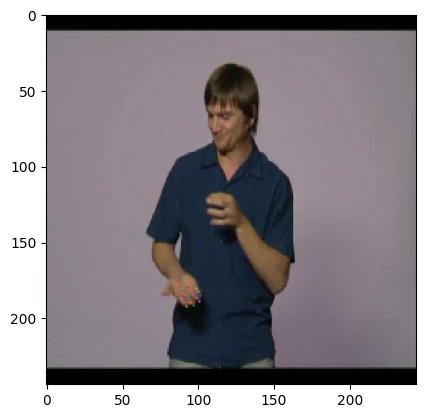

In [4]:
imgIndex = 500
plt.imshow(training_images[imgIndex])
for i in training_labels[imgIndex]:
    plt.plot(i[0],i[1],".",markersize=1)

In [5]:
training_labelsL = training_labels[:,:5,:2].reshape(len(training_labels),-1)
print(len(training_labelsL),training_labels.shape,training_labelsL.shape,training_images.shape,training_labelsL[0])

1500 (1500, 21, 3) (1500, 10) (1500, 244, 244, 3) [161.48670521 177.12198215 159.631567   178.18744269 157.96691418
 179.25176561 155.06893482 186.00085449 155.82766514 190.5154775 ]


In [6]:
def model_load() :
    preprocess_input = tf.keras.applications.resnet.preprocess_input

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(training_images.shape[1],training_images.shape[2],3),#( 540, 960, 3),
    )

    base_model.trainable = True
    print(len(base_model.layers))
    for i in range(len(base_model.layers)- 27) : 
    #for i in range(0,127) : 
         base_model.layers[i].trainable = False

    inputLayer = layers.Input(shape=(training_images.shape[1],training_images.shape[2],3))
    x = preprocess_input(inputLayer)
    # x = layers.Conv2D(3, (3,3), padding = 'same', activation = 'linear',
    #                       kernel_initializer = tf.keras.initializers.glorot_uniform(seed=0))(x)
    # x = layers.MaxPool2D(1,strides=(2,2))(x)
    # x = layers.Conv2D(3, (3,3), padding = 'same')(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x) 
    # x = layers.MaxPool2D(pool_size=(2, 2))(x) 
    # x = layers.Flatten()(x) 
    # x = layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(x) 
    # x = layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(x) 
    x = layers.Dropout(0.3)(x)
    # x = layers.SeparableConv2D(
    #     training_labelsL.shape[1], kernel_size=5, strides=1, activation="relu"
    # )(x)
    # prediction_layer = layers.SeparableConv2D(
    #     training_labelsL.shape[1], kernel_size=3, strides=1, activation="relu"
    # )(x)
    #x = layers.Dense(1500)(x)
    #x = layers.Dense(1000)(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(500)(x)
    #x = layers.Dense(250)(x)
    #x = layers.Dense(100)(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(70)(x)

    prediction_layer = layers.Dense(training_labelsL.shape[1])(x)


    return tf.keras.Model(inputs=inputLayer,outputs=prediction_layer)

In [7]:
model = model_load()

175


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
      loss=tf.keras.losses.MeanSquaredError()
    ,
      metrics= [ 
          tf.keras.metrics.RootMeanSquaredError(name='rmse'),
          'acc'
      ]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 244, 244, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 244, 244, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="rmse", patience=50, restore_best_weights=True
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='rmse', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

In [10]:
test_labels,test_images = utils.get_test_data(size=200)
test_labelsL = test_labels[:,:5,:2].reshape(len(test_labels),-1)

In [12]:
with tf.device("/GPU:0"):
    #for i in range(4):
    model_history = model.fit(training_images, training_labelsL,
                              epochs=20, 
                              callbacks = [early_stopping, rlp],
                              validation_data=(test_images,test_labelsL),
                               workers=4, use_multiprocessing=True,batch_size=32
                             )

Epoch 1/20
47/47 [==============================] - 12s 254ms/step - loss: 1105.5095 - rmse: 33.2492 - acc: 0.2013 - val_loss: 1625.3315 - val_rmse: 40.3154 - val_acc: 0.3550 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 12s 250ms/step - loss: 972.2371 - rmse: 31.1807 - acc: 0.2260 - val_loss: 1592.9478 - val_rmse: 39.9118 - val_acc: 0.1750 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 11s 245ms/step - loss: 1102.6772 - rmse: 33.2066 - acc: 0.2127 - val_loss: 1707.3021 - val_rmse: 41.3195 - val_acc: 0.0650 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 12s 246ms/step - loss: 977.0336 - rmse: 31.2575 - acc: 0.2247 - val_loss: 1700.0239 - val_rmse: 41.2313 - val_acc: 0.3550 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 12s 256ms/step - loss: 969.3306 - rmse: 31.1341 - acc: 0.2287 - val_loss: 1761.1971 - val_rmse: 41.9666 - val_acc: 0.1750 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 12s 256ms/s

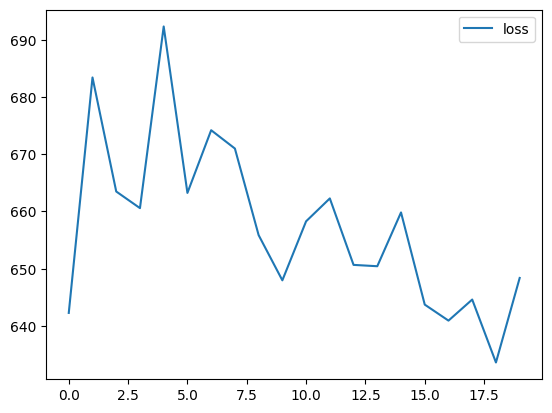

In [14]:
plt.plot(model_history.history['loss'][:])
# plt.plot(model_history.history['rmse'])
#plt.plot(model_history.history['acc'])
# plt.plot(model_history.history['val_loss'])
# plt.plot(model_history.history['val_rmse'])
# plt.plot(model_history.history['val_acc'])
# plt.plot(model_history.history['lr'])

plt.legend(['loss','rmse','acc','val_loss','val_rmse','val_acc','lr'])

In [24]:
test_labels2,test_images2 = utils.get_test_data(True,size=700)
test_labelsL2 = test_labels2[:,:5,:2].reshape(len(test_labels2),-1)

In [25]:
model.evaluate(test_images2,test_labels2)

InvalidArgumentError: Graph execution error:

Detected at node 'cond_1/remove_squeezable_dimensions/cond/Squeeze' defined at (most recent call last):
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_18632\555579040.py", line 1, in <module>
      model.evaluate(test_images2,test_labels2)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1668, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics\base_metric.py", line 693, in update_state
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 209, in squeeze_or_expand_dimensions
      y_true, y_pred = tf.cond(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 204, in <lambda>
      squeeze_dims = lambda: remove_squeezable_dimensions(y_true, y_pred)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 155, in remove_squeezable_dimensions
      labels = tf.cond(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 157, in <lambda>
      lambda: tf.squeeze(labels, [-1]),
Node: 'cond_1/remove_squeezable_dimensions/cond/Squeeze'
Detected at node 'cond_1/remove_squeezable_dimensions/cond/Squeeze' defined at (most recent call last):
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_18632\555579040.py", line 1, in <module>
      model.evaluate(test_images2,test_labels2)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1668, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics\base_metric.py", line 693, in update_state
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 209, in squeeze_or_expand_dimensions
      y_true, y_pred = tf.cond(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 204, in <lambda>
      squeeze_dims = lambda: remove_squeezable_dimensions(y_true, y_pred)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 155, in remove_squeezable_dimensions
      labels = tf.cond(
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\losses_utils.py", line 157, in <lambda>
      lambda: tf.squeeze(labels, [-1]),
Node: 'cond_1/remove_squeezable_dimensions/cond/Squeeze'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Can not squeeze dim[2], expected a dimension of 1, got 3
	 [[{{node cond_1/remove_squeezable_dimensions/cond/Squeeze}}]]
	 [[cond/then/_11/cond/cond/pivot_f/_96/_103]]
  (1) INVALID_ARGUMENT:  Can not squeeze dim[2], expected a dimension of 1, got 3
	 [[{{node cond_1/remove_squeezable_dimensions/cond/Squeeze}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_83144]

In [ ]:
    x = layers.Conv2D(128, (3, 3),strides=1,activation='relu',padding = 'same', input_shape=(244, 244, 1))(inputLayer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), strides=1,activation='relu',padding = 'same')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), strides=1,activation='relu',padding = 'same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), strides=1,activation='relu',padding = 'same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='relu')(x)